In [1]:
# True: Google Colab Notebook
# False: My local PC
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !ls /content/drive/MyDrive/output/otto/
    base_path = '/content/drive/MyDrive'
else:
    base_path = '../data'

# Preprocessing

In [2]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

In [3]:
#test = pd.read_parquet('/content/drive/MyDrive/output/otto/test.parquet')
test = pd.read_parquet(f'{base_path}/output/otto/test_50_tmp.parquet')

In [4]:
DEBUG_MODE = False
#DEBUG_MODE = True

if DEBUG_MODE:
    test = test.head(100000)
IGNORE_COL = ['session','aid']

type_list = ['clicks', 'carts', 'orders']
#type_list = ['carts', 'orders']


#TYPE_MODE = 'clicks'
#TYPE_MODE = 'carts'
#TYPE_MODE = 'orders'

In [5]:
def reduce_memory(df):
    df['session'] = df['session'].astype('int32')
    df['aid'] = df['aid'].astype('int32')
    df['score_click'] = df['score_click'].astype('float32')
    df['score_cart'] = df['score_cart'].astype('float32')
    df['score_buy'] = df['score_buy'].astype('float32')
    df['score_click_only'] = df['score_click_only'].astype('float32')
    df['score_cart_only'] = df['score_cart_only'].astype('float32')
    df['score_buy_only'] = df['score_buy_only'].astype('float32')
    df['session_action_count'] = df['session_action_count'].astype('int16')
    df['session_click_count'] = df['session_click_count'].astype('int16')
    df['session_cart_count'] = df['session_cart_count'].astype('int16')
    df['session_order_count'] = df['session_order_count'].astype('int16')
    df['session_type_mean'] = df['session_type_mean'].astype('float32')
    
    click_topn_list = [10, 20]
    for i in click_topn_list:
        df[f'n_clicks_{i}'] = df[f'n_clicks_{i}'].astype('int8')

    df['n_carts'] = df['n_carts'].astype('int8')
    df['n_buys'] = df['n_buys'].astype('int8')
    df['clicks_count'] = df['clicks_count'].astype('int32')
    df['carts_count'] = df['carts_count'].astype('int16')
    df['orders_count'] = df['orders_count'].astype('int16')
    return df

In [6]:
def join_session_features(df):
    session_df = pd.read_parquet(f'{base_path}/output/otto/valid_session_features.parquet')
    session_df['session'] = session_df['session'].astype('int32')
    session_df[f'session_action_count'] = session_df[f'session_action_count'].astype('int16')
    session_df[f'session_click_count'] = session_df[f'session_click_count'].astype('int16')
    session_df[f'session_cart_count'] = session_df[f'session_cart_count'].astype('int16')
    session_df[f'session_order_count'] = session_df[f'session_order_count'].astype('int16')
    session_df[f'session_type_mean'] = session_df[f'session_type_mean'].astype('float32')
    session_df[f'session_click_rate'] = session_df[f'session_click_rate'].astype('float32')
    session_df[f'session_cart_rate'] = session_df[f'session_cart_rate'].astype('float32')
    session_df[f'session_order_rate'] = session_df[f'session_order_rate'].astype('float32')

    remove_col = ['session_action_count', 'session_click_count', 'session_cart_count', 'session_order_count', 'session_type_mean']
    df = df.drop(remove_col , axis=1)
    df = df.merge(session_df, 'left', 'session')
    del session_df
    gc.collect()
    
    return df

In [7]:
def join_aid_features(df):
    aid_df = pd.read_parquet(f'{base_path}/output/otto/test_aid_features.parquet')
    week_list = ['4weeks', '2weeks', '1week']
    aid_df['aid'] = aid_df['aid'].astype('int32')
    for i in week_list:
        aid_df[f'clicks_count_{i}'] = aid_df[f'clicks_count_{i}'].astype('int32')
        aid_df[f'carts_count_{i}'] = aid_df[f'carts_count_{i}'].astype('int16')
        aid_df[f'orders_count_{i}'] = aid_df[f'orders_count_{i}'].astype('int16')
        aid_df[f'clicks_rank_{i}'] = aid_df[f'clicks_rank_{i}'].astype('int32')
        aid_df[f'carts_rank_{i}'] = aid_df[f'carts_rank_{i}'].astype('int32')
        aid_df[f'orders_rank_{i}'] = aid_df[f'orders_rank_{i}'].astype('int32')
        for j in ['clicks', 'carts', 'orders']:
            for k in [2,4]:
                aid_df[f'aid_{j}_count_rate_1_{k}'] = aid_df[f'aid_{j}_count_rate_1_{k}'].astype('float32')


    remove_col = ['clicks_rank', 'carts_rank', 'orders_rank', 'clicks_count', 'carts_count', 'orders_count']
    #remove_col = ['clicks_rank_1week', 'carts_rank_1week', 'orders_rank_1week', 'clicks_count_1week', 'carts_count_1week', 'orders_count_1week']
    #df = df.drop(remove_col , axis=1)
    df = df.merge(aid_df, 'left', 'aid')
    #del session_df
    #gc.collect()
    
    return df

In [8]:
test = reduce_memory(test)

In [12]:
# 他のtargetの予測値を追加
#TRAIN_SECOND = False
TRAIN_SECOND = True

if TRAIN_SECOND:
    print('second train.....')
    # carts
    test_carts = test[['session', 'aid']]
    carts_pred = pd.read_csv(f'{base_path}/otto/test_oof_lgbm_carts.csv')
    carts_pred = carts_pred.rename(columns={'score': 'carts_pred_score'})
    test_carts = pd.concat([test_carts, carts_pred], axis=1)
    del carts_pred
    gc.collect()
    # clicks
    test_clicks = test[['session', 'aid']]
    clicks_pred = pd.read_csv(f'{base_path}/otto/test_oof_lgbm_clicks.csv')
    clicks_pred = clicks_pred.rename(columns={'score': 'clicks_pred_score'})
    test_clicks = pd.concat([test_clicks, clicks_pred], axis=1)
    del clicks_pred
    gc.collect()

second train.....


In [13]:
if TRAIN_SECOND:
    print('second train join.....')
    # join carts
    test = test.merge(test_carts, how='left', on=['session', 'aid'])
    print('carts_pred_score_mean:', test['carts_pred_score'].mean())
    print('cart_pred feature null rate:', test['carts_pred_score'].isnull().sum() / test.shape[0])
    del test_carts
    gc.collect()
    # join clicks
    test = test.merge(test_clicks, how='left', on=['session', 'aid'])
    print('clicks_pred_score_mean:', test['clicks_pred_score'].mean())
    print('click_pred feature null rate:', test['clicks_pred_score'].isnull().sum() / test.shape[0])
    del test_clicks
    gc.collect()

second train join.....
carts_pred_score_mean: 0.027714523797333086
cart_pred feature null rate: 0.0
clicks_pred_score_mean: 0.03328267490127212
click_pred feature null rate: 0.0


In [14]:
test.shape

(143574745, 25)

In [15]:
# join aid and session features
test = join_session_features(test)
test = join_aid_features(test)

In [16]:
test

,session,aid,score_click,score_cart,score_buy,score_click_only,score_cart_only,score_buy_only,n_clicks_10,n_clicks_20,n_carts,n_buys,clicks_rank,carts_rank,orders_rank,clicks_count,carts_count,orders_count,carts_pred_score,clicks_pred_score,session_action_count,session_click_count,session_cart_count,session_order_count,session_type_mean,session_click_rate,session_cart_rate,session_order_rate,clicks_count_4weeks,carts_count_4weeks,orders_count_4weeks,clicks_rank_4weeks,carts_rank_4weeks,orders_rank_4weeks,clicks_count_2weeks,carts_count_2weeks,orders_count_2weeks,clicks_rank_2weeks,carts_rank_2weeks,orders_rank_2weeks,clicks_count_1week,carts_count_1week,orders_count_1week,clicks_rank_1week,carts_rank_1week,orders_rank_1week,aid_clicks_count_rate_1_2,aid_clicks_count_rate_1_4,aid_carts_count_rate_1_2,aid_carts_count_rate_1_4,aid_orders_count_rate_1_2,aid_orders_count_rate_1_4
0,12899779,59625,0.071773,0.071773,0.0,0.071773,0.0,0.0,-1,-1,-1,-1,601483,-1,-1,1,0,0,0.877453,0.783422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0,0,-1,-1,-1,3,0,0,-1,-1,-1,1,0,0,658898,-1,-1,0.333333,0.125000,0.000000,0.000000,0.000000,0.000000
1,12899780,582732,0.252664,0.252664,0.0,0.252664,0.0,0.0,3,6,4,4,1356,1157,1301,333,33,5,0.406584,0.716470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15707,1554,574,324,252,220,4603,451,172,479,375,245,333,33,5,1362,1155,1364,0.072344,0.021201,0.073171,0.021236,0.029070,0.008711
2,12899780,736515,0.711190,0.711190,0.0,0.711190,0.0,0.0,22,41,36,33,711,297,459,488,67,8,0.457967,0.635433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17555,1753,701,255,202,144,4996,561,226,405,251,138,488,67,8,712,296,470,0.097678,0.027798,0.119430,0.038220,0.035398,0.011412
3,12899780,973453,0.464086,0.464086,0.0,0.464086,0.0,0.0,-1,-1,-1,-1,9547,13316,-1,87,7,0,0.379001,0.720863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8862,1008,439,917,576,365,1415,130,53,3449,3184,2198,87,7,0,9538,13077,-1,0.061484,0.009817,0.053846,0.006944,0.000000,0.000000
4,12899780,1142000,1.071773,1.071773,0.0,1.071773,0.0,0.0,4,12,7,6,750,1114,1276,473,33,5,0.724009,0.615949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25288,1242,503,106,383,287,6205,291,112,269,825,566,473,33,5,749,1127,1094,0.076229,0.018705,0.113402,0.026570,0.044643,0.009940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574740,14571581,145332,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,45,162,62,30,1040,142,26,0.000354,0.000996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3957,695,251,3437,1069,1021,3532,604,222,769,214,141,1040,142,26,162,63,30,0.294451,0.262825,0.235099,0.204317,0.117117,0.103586
143574741,14571581,1336175,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,46,298,179,31,775,86,25,0.005456,0.002075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4594,661,245,2687,1172,1069,2286,293,113,1584,822,556,775,86,25,298,179,35,0.339020,0.168698,0.293515,0.130106,0.221239,0.102041
143574742,14571581,714524,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,47,104,56,32,1233,148,25,0.000330,0.001162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36603,3263,831,39,55,96,11361,1109,260,75,65,100,1233,148,25,104,55,34,0.108529,0.033686,0.133454,0.045357,0.096154,0.030084
143574743,14571581,1359971,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,48,110,60,33,1205,146,25,0.000313,0.001072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24252,3117,763,121,64,118,9450,1144,267,108,59,94,1205,146,25,110,60,32,0.127513,0.049687,0.127622,0.046840,0.093633,0.032765


In [17]:
n_splits = 5
session_splits = 5

In [18]:
min_val = test['session'].min()
max_val = test['session'].max()
print('min session:', min_val, 'max_session:', max_val)

session_splits_list = [int(min_val) + int(i*(max_val - min_val) / session_splits) for i in range(session_splits)]
print('session_splits=', session_splits)
print('session_splits_list=', session_splits_list)

min session: 12899779 max_session: 14571581
session_splits= 5
session_splits_list= [12899779, 13234139, 13568499, 13902860, 14237220]


# Read Models

In [19]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

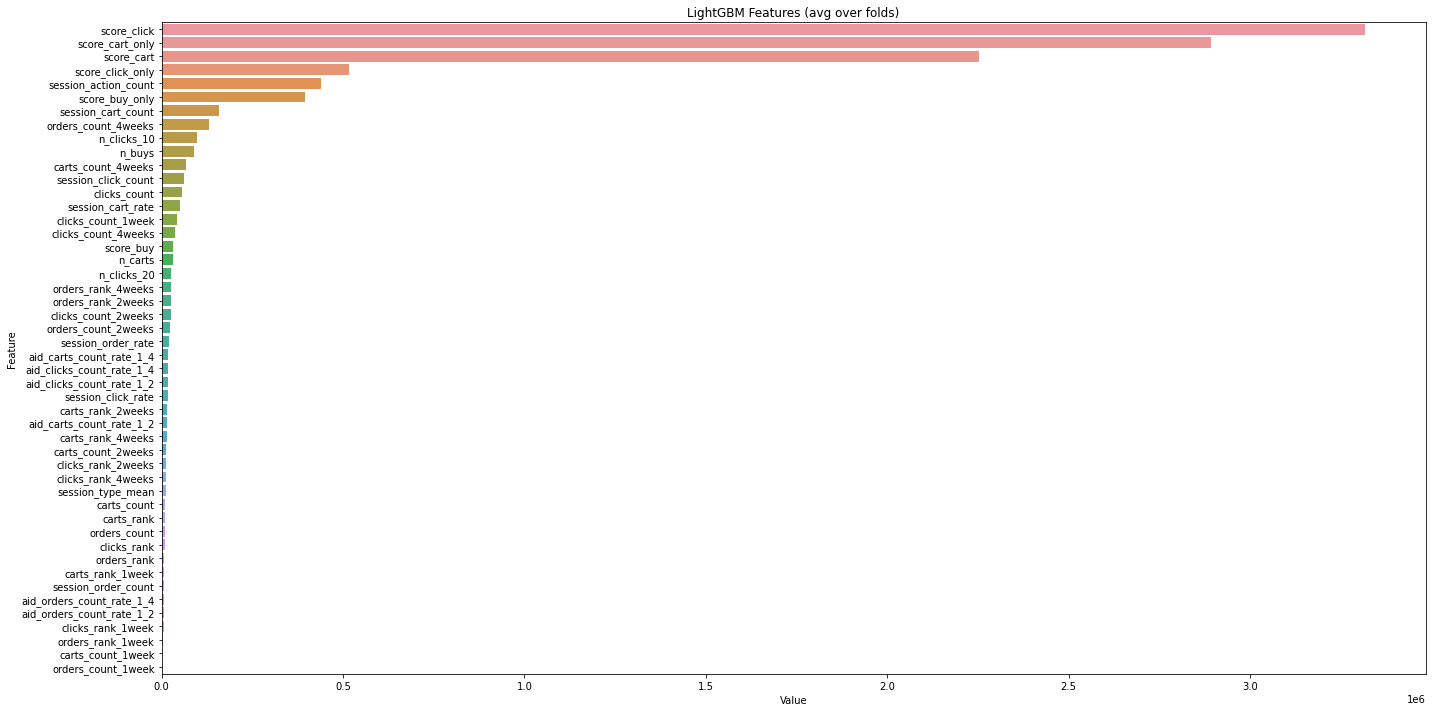

In [20]:
#model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_clicks.pkl', allow_pickle=True)
model = np.load(f'{base_path}/otto/otto_lgbm_fold0_orders.pkl', allow_pickle=True)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

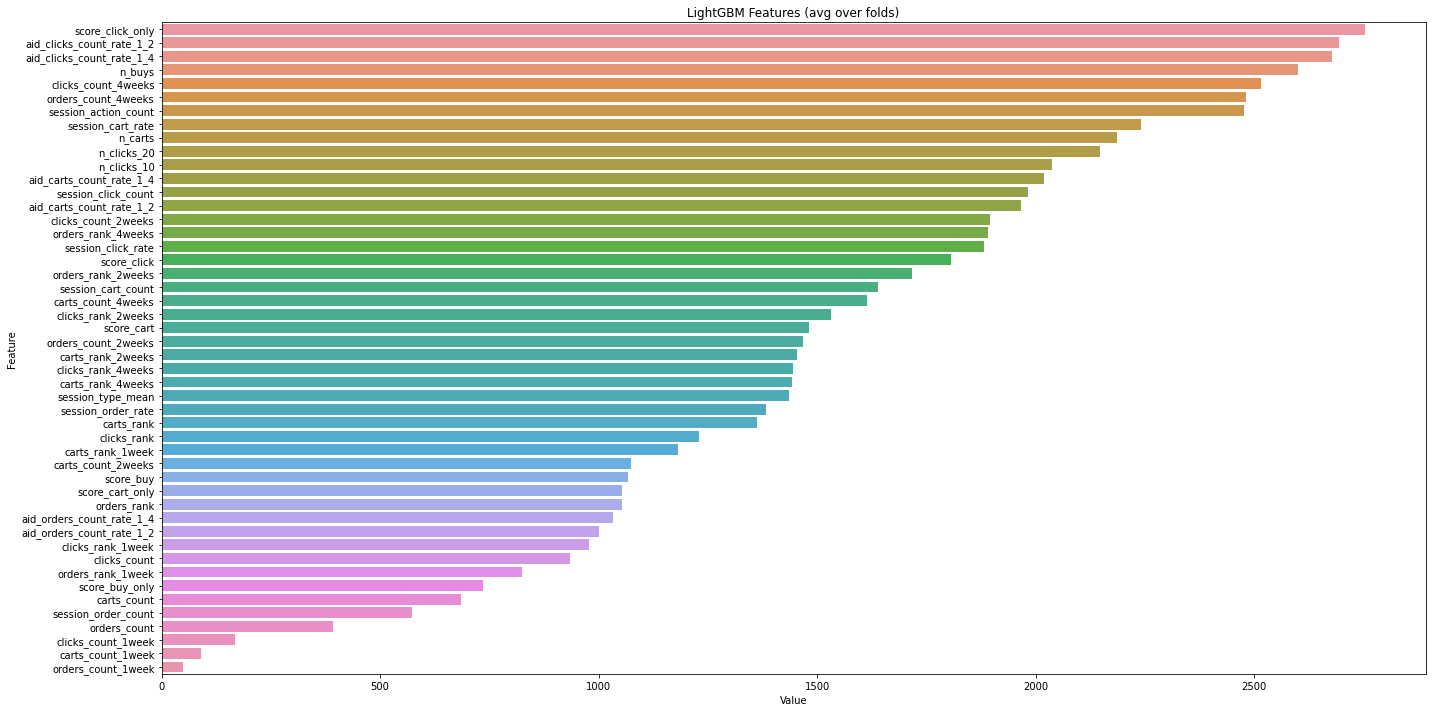

In [21]:
#model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_clicks.pkl', allow_pickle=True)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [22]:
#ans_list = []
# 分割してpredictするための準備
Nrow = test.shape[0]
Ndiv = 10
n = int(Nrow // Ndiv) + 1
x_test = test.drop(IGNORE_COL , axis=1)
x_test_list = []
for i in range(Ndiv):
    tmp = x_test.iloc[i*n : (i+1)*n, :]
    x_test_list.append(tmp)
del x_test
gc.collect()

if TRAIN_SECOND:
    tmp_type_list = ['orders']
else:
    tmp_type_list = type_list

for target in tmp_type_list:
    print('target=', target,'*************')
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))

    # fold looop 
    for fold in range(n_splits):
        print('fold=', fold)
        if TRAIN_SECOND and target == 'orders':
            model = np.load(f'{base_path}/otto/otto_lgbm_fold{fold}_{target}_second.pkl', allow_pickle=True)
        else:
            model = np.load(f'{base_path}/otto/otto_lgbm_fold{fold}_{target}.pkl', allow_pickle=True)

        test_pred_list = [] 
        for i, v in enumerate(x_test_list):
            print('test pred i=', i)
            tmp = model.predict(v)
            test_pred_list.append(tmp) 

        test_pred = np.concatenate(test_pred_list)
        del test_pred_list, model
        gc.collect()

        # testの場合はfoldの数で割る
        test_predictions += test_pred / n_splits
    
    # dfに変換していったん保存
    test_predictions = pd.DataFrame(test_predictions, columns=["score"])
    #test_predictions.to_parquet(f'{base_path}/otto/test_predictions_{target}.parquet')
    if TRAIN_SECOND and target == 'orders':
        test_predictions.to_csv(f'{base_path}/otto/test_oof_lgbm_{target}_second.csv', index = False)
    else:
        test_predictions.to_csv(f'{base_path}/otto/test_oof_lgbm_{target}.csv', index = False)
    del test_predictions
    gc.collect()

del x_test_list
gc.collect()

target= orders *************
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 1
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 2
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 3
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9
fold= 4
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
test pred i= 5
test pred i= 6
test pred i= 7
test pred i= 8
test pred i= 9


0

## Load and Merge type

In [20]:
sub_df_list = []

# 今後はこの2つのcolumnsしか使わないので削っておく
test = test[['session', 'aid']]

for i, t in enumerate(type_list):
    print(i, t)
    #df = pd.read_parquet(f'{base_path}/otto/test_predictions_{t}.parquet')
    if TRAIN_SECOND and t == 'orders':
        score = pd.read_csv(f'{base_path}/otto/test_oof_lgbm_{t}_second.csv')
    else:
        score = pd.read_csv(f'{base_path}/otto/test_oof_lgbm_{t}.csv')
    pred_df = pd.concat([test, score], axis=1)
    pred_df['aid'] = pred_df['aid'].astype('int32')
    del score
    gc.collect()
    for j in range(session_splits):
        print('splits session: ',j ,' from ' , session_splits_list[j])
        # last loop
        if j == session_splits - 1:
            tmp = pred_df[session_splits_list[j] <= pred_df['session']]
        else:
            tmp = pred_df[(session_splits_list[j] <= pred_df['session']) & (pred_df['session'] < session_splits_list[j+1])]
        tmp['session_type'] = tmp['session'].apply(lambda x: str(x) + f'_{t}')
        tmp = tmp.drop('session',axis=1)
        tmp = tmp.sort_values(['session_type','score'],ascending=[True, False]).reset_index(drop=True)
        tmp['n'] = tmp.groupby('session_type').cumcount().astype('int16')
        tmp = tmp.loc[tmp.n<20].drop(['n','score'],axis=1)
        tmp = tmp.groupby('session_type')['aid'].apply(list).reset_index()
        tmp['labels'] = tmp['aid'].map(lambda x: ''.join(str(x)[1:-1].split(',')))
        tmp = tmp.drop(['aid'],axis=1)
        sub_df_list.append(tmp)
        
    #pred_df['session_type'] = pred_df['session'].apply(lambda x: str(x) + f'_{t}')
    #pred_df = pred_df.drop('session',axis=1)
    #pred_df = pred_df.sort_values(['session_type','score'],ascending=[True, False]).reset_index(drop=True)
    #pred_df['n'] = pred_df.groupby('session_type').cumcount().astype('int16')
    #pred_df = pred_df.loc[pred_df.n<20].drop(['n','score'],axis=1)
    #print(pred_df.dtypes)
    #pred_df = pred_df.groupby('session_type')['aid'].apply(list).reset_index()
    #pred_df['labels'] = pred_df['aid'].map(lambda x: ''.join(str(x)[1:-1].split(',')))
    #pred_df = pred_df.drop(['aid'],axis=1)
    #sub_df_list.append(pred_df)
del tmp, test
gc.collect()

0 clicks
splits session:  0  from  12899779
splits session:  1  from  13234139
splits session:  2  from  13568499
splits session:  3  from  13902860
splits session:  4  from  14237220
1 carts
splits session:  0  from  12899779
splits session:  1  from  13234139
splits session:  2  from  13568499
splits session:  3  from  13902860
splits session:  4  from  14237220
2 orders
splits session:  0  from  12899779
splits session:  1  from  13234139
splits session:  2  from  13568499
splits session:  3  from  13902860
splits session:  4  from  14237220


0

In [21]:
#pred_df = pd.concat([sub_df_list[0], sub_df_list[1], sub_df_list[2]])
pred_df = pd.concat(sub_df_list)
del sub_df_list
gc.collect()

0

In [22]:
pred_df.to_csv(f"{base_path}/output/otto/test_preds.csv", index=False)
pred_df.head()

,session_type,labels
0,12899779_clicks,59625 1253524 737445 731692 438191 94230 17907...
1,12899780_clicks,973453 582732 736515 1142000 889686 1360606 48...
2,12899781_clicks,199008 918667 194067 57315 141736 811084 75943...
3,12899782_clicks,595994 413962 834354 1007613 1494780 1669402 2...
4,12899783_clicks,255297 1817895 198385 300127 607638 1729553 17...


In [23]:
pred_df.shape

(5015409, 2)